In [24]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, signal
import matplotlib.pyplot as plt

# Regression of Friedlingstein feedback eqn

dU = beta * dC + gamma * dT

regress -dU against dC, slope = beta and intercept = gamma * dT

In [11]:
GCP = pd.read_csv("./../../Prelim_Data_Analysis/gcb_data/budget.csv",
                  index_col=0,
                  skipfooter=1,
                  usecols=[0,4,5,6]
                 )
GCP['CO2'] = pd.read_csv("./../co2_temp_data/co2/co2_global.csv", index_col=0, header=0)[2:]
GCP['land sink'] = -GCP['land sink']
GCP['ocean sink'] = -GCP['ocean sink']
GCP['budget imbalance'] = -GCP["budget imbalance"] + GCP['land sink']
GCP.rename(columns={"ocean sink": "ocean",
                    "land sink": "land (model)",
                    "budget imbalance": "land"
                   },
           inplace=True)
GCP.head()

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


In [13]:
C = GCP.CO2
C.head()

Year
1959    315.486
1960    316.163
1961    316.856
1962    317.558
1963    318.268
Name: CO2, dtype: float64

In [14]:
land = -GCP.land
land.head()

Year
1959    1.376389
1960    1.916752
1961    1.818860
1962    2.307954
1963    2.233127
Name: land, dtype: float64

In [87]:
ocean = -GCP.ocean
ocean.head()

Year
1959    0.852376
1960    0.819017
1961    0.714842
1962    0.756709
1963    0.904997
Name: ocean, dtype: float64

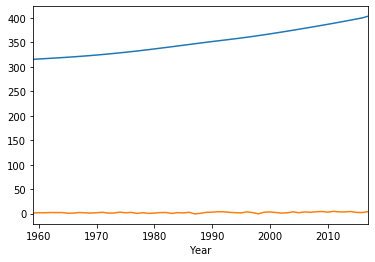

In [15]:
C.plot(); land.plot()

In [17]:
pd.DataFrame([C, land])

Year,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
CO2,315.486000,316.163000,316.85600,317.558000,318.268000,318.997000,319.757000,320.560000,321.410000,322.31000,...,382.892000,384.927000,386.995000,389.101000,391.248000,393.435000,395.651000,397.886000,400.130000,403.522500
land,1.376389,1.916752,1.81886,2.307954,2.233127,2.277164,0.922264,1.054875,2.384113,1.71958,...,3.880837,4.444837,3.036445,4.738535,3.624237,3.528228,4.410669,2.531232,2.358355,4.106298


In [18]:
stats_info = stats.linregress(C-280, land)
stats_info

LinregressResult(slope=0.023930300605221336, intercept=0.5764234984647114, rvalue=0.5358735325843046, pvalue=1.2206527776897123e-05, stderr=0.004993951437733341)

In [19]:
beta = stats_info[0] # slope = beta
intercept = stats_info[1]
beta, intercept

(0.023930300605221336, 0.5764234984647114)

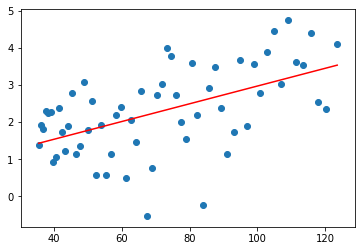

In [20]:
y = beta*(C-280)+ intercept
plt.plot(C-280,y, color='r')
plt.scatter(C-280, land)

In [23]:
# dT around 1 degC
gamma = intercept/1

In [22]:
beta, gamma

(0.023930300605221336, 0.5764234984647114)

Caveats:
- make sure that the values of C, land and dT are correct in accordance to feedback analysis in Friedlingstein2003.
- temperature has changed over the years too, can't just assign dT to one value. It means that temperature influences uptake non-linearly. Could we 'adjust' this by implementing the dT for each year (which would increase the intercept incremently each year)?

# Calculating beta and detecting depatures from linear

Calculate a linear beta using the rolling gradient function, which calculates a time series of the trend of uptake against CO2 (effectively beta). If this timeseries is non-linear, then something else could be driving uptake

In [34]:
land.loc[1959:1959+10]

Year
1959    1.376389
1960    1.916752
1961    1.818860
1962    2.307954
1963    2.233127
1964    2.277164
1965    0.922264
1966    1.054875
1967    2.384113
1968    1.719580
1969    1.204671
Name: land, dtype: float64

LinregressResult(slope=0.02879814903541788, intercept=-55.517280847692106, rvalue=0.9708966153199413, pvalue=4.5163482440701956e-37, stderr=0.0009409311183714584)

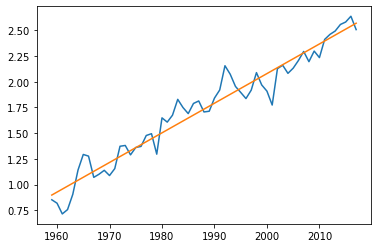

In [123]:
plt.plot(ocean)
plt.plot(ocean.index, stats.linregress(ocean.index, ocean.values)[0]*ocean.index + stats.linregress(ocean.index, ocean.values)[1])
stats.linregress(ocean.index, ocean.values)

In [73]:
def rolling_trend(x, window_size=25, plot=False):

    roll_vals = []
    for i in range(0, len(x.index) - window_size):
        sub = x.iloc[i:i+window_size+1]

        linreg = stats.linregress(sub.values.squeeze(), sub.index)

        roll_vals.append(linreg[0])


    roll_df = pd.DataFrame({f"{window_size}-year trend slope": roll_vals}, index=x.index[:-window_size])

    if plot:

        plt.figure(figsize=(22,16))

        plt.subplot(211)
        plt.plot(x)
        plt.ylabel("C flux to the atmosphere (GtC)", fontsize=20)

        plt.subplot(212)
        plt.plot(roll_df, color='g')
        plt.ylabel("Slope of C flux trend (GtC/ppm/yr)", fontsize=20)           

    return roll_df

In [74]:
def bandpass(x, fc, fs=1, order=5, btype="low", deseasonalise_first=False):

    if deseasonalise_first:
        mean_list = []
        for i in range(12):
            indices = range(i, len(x)+i, 12)
            sub = x[indices]
            mean_list.append(np.mean(sub))

        s = []
        for i in range(int(len(x)/12)):
            for j in mean_list:
                s.append(j)
        s = np.array(s)

        x = x - (s-np.mean(s))

    if btype == "band":
        assert type(fc) == list, "fc must be a list of two values."
        fc = np.array(fc)

    w = fc / (fs / 2) # Normalize the frequency.
    b, a = signal.butter(order, w, btype)

    return signal.filtfilt(b, a, x)

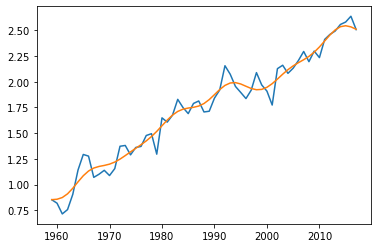

In [93]:
plt.plot(ocean)
plt.plot(ocean.index, bandpass(ocean, 1/10))

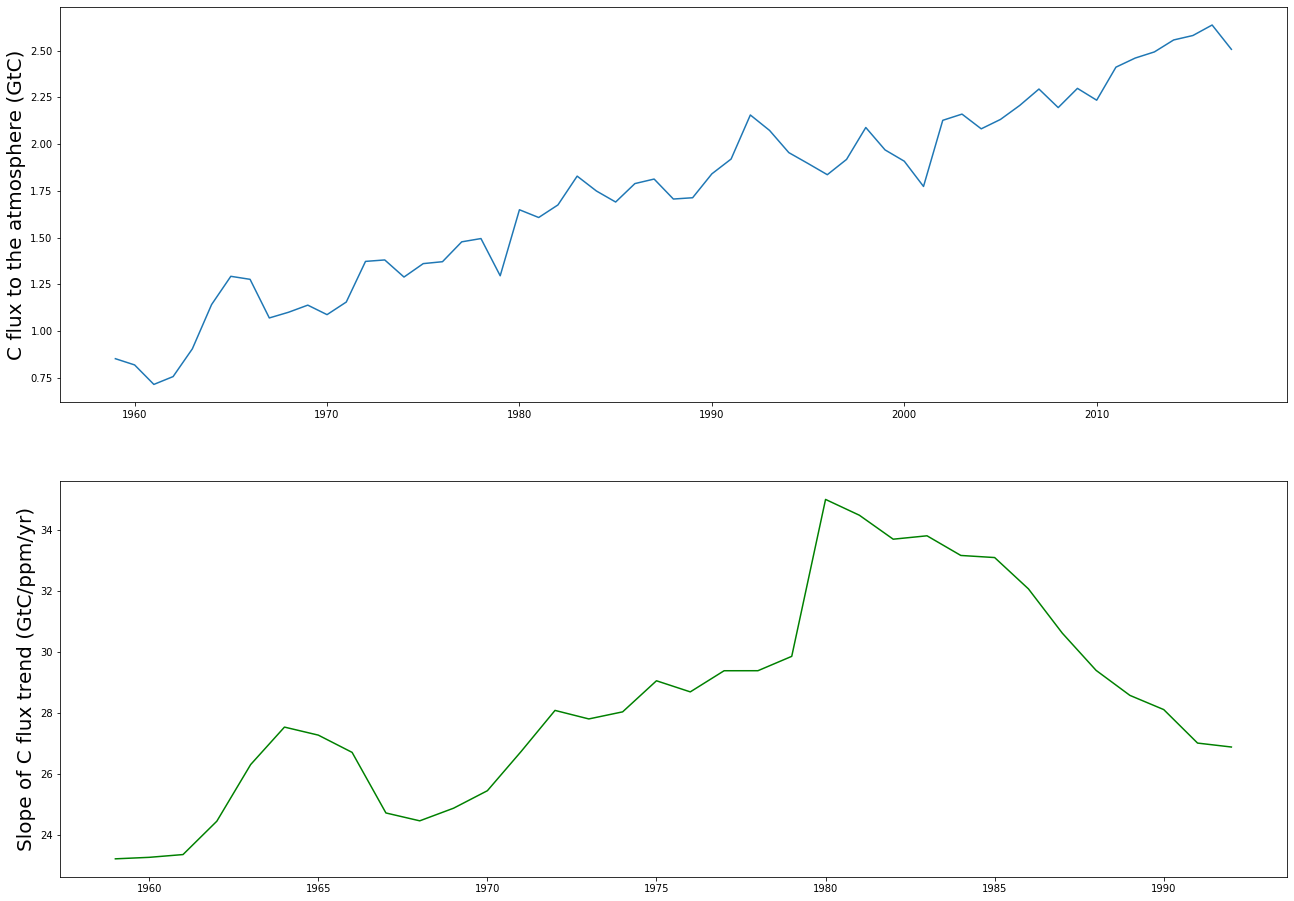

In [92]:
rolling_trend(ocean, window_size=25, plot=True);

In [115]:
bandpass(land.values, 1/10)

array([1.3804123 , 1.66632813, 1.88824554, 2.00453467, 2.00575862,
       1.9158778 , 1.78243625, 1.65978395, 1.59168677, 1.59917282,
       1.67671552, 1.79658422, 1.91891247, 2.00414898, 2.02465912,
       1.97274371, 1.86289446, 1.72697077, 1.60283579, 1.51985503,
       1.48712664, 1.49035111, 1.49995517, 1.48769309, 1.44426708,
       1.38919924, 1.36709682, 1.43029536, 1.61424889, 1.91639649,
       2.28919533, 2.65245054, 2.92088187, 3.03495217, 2.98118792,
       2.79368172, 2.5377774 , 2.28473419, 2.08875167, 1.97496377,
       1.94124127, 1.97055854, 2.04641058, 2.16307662, 2.32599171,
       2.54321053, 2.81349223, 3.11768781, 3.41814884, 3.66733798,
       3.82307738, 3.86496735, 3.80540054, 3.68986713, 3.58471564,
       3.55526054, 3.64160625, 3.84188652, 4.11102464])

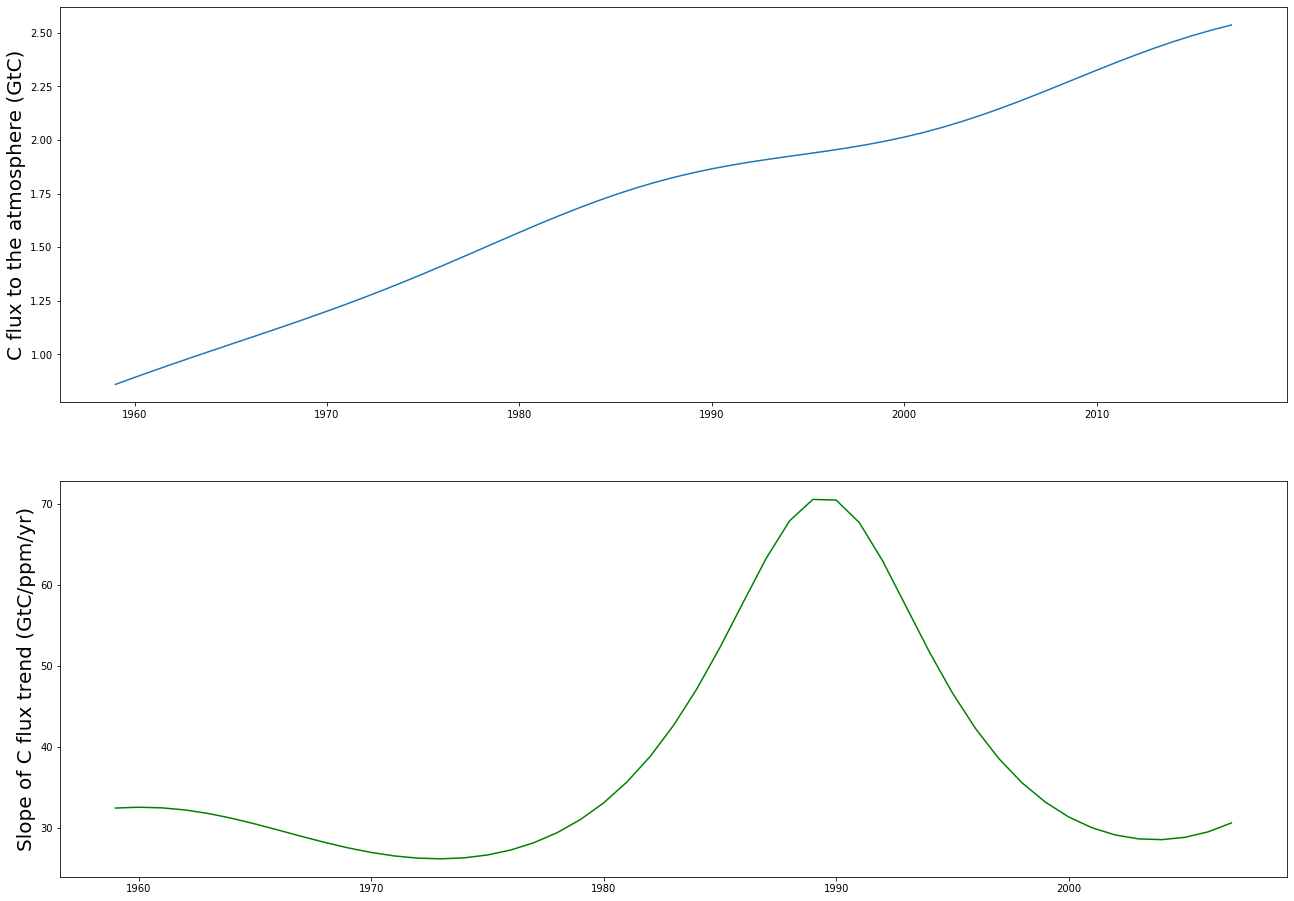

In [116]:
rolling_trend(pd.DataFrame({"vals": bandpass(ocean, 1/25)}, index=land.index),
              window_size=10,
              plot=True
             );

# Ordinary Least Squares Regression

Need uptake, CO2 and temp. at same temporal resolution (either annual or monthly where data is deseasonalised).
Perform OLS using statsmodels.

Unlike from before Lit Review, we will need to perform this as a rolling gradient with 10 year window sizes.

In [95]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [102]:
temp_med = pd.read_csv("./../co2_temp_data/temp/HADCRUT4_annual.txt", delim_whitespace=True,
                       index_col="Year", skipfooter=1
                      )
temp_med = temp_med["Ann"]
temp_med

C:\Users\Ross\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


Year
1959    0.017
1960   -0.049
1961    0.038
1962    0.014
1963    0.048
1964   -0.223
1965   -0.140
1966   -0.068
1967   -0.074
1968   -0.113
1969    0.032
1970   -0.027
1971   -0.186
1972   -0.065
1973    0.062
1974   -0.214
1975   -0.149
1976   -0.241
1977    0.047
1978   -0.062
1979    0.057
1980    0.092
1981    0.140
1982    0.011
1983    0.194
1984   -0.014
1985   -0.030
1986    0.045
1987    0.192
1988    0.198
1989    0.118
1990    0.296
1991    0.254
1992    0.105
1993    0.148
1994    0.208
1995    0.325
1996    0.183
1997    0.390
1998    0.539
1999    0.306
2000    0.294
2001    0.441
2002    0.496
2003    0.505
2004    0.447
2005    0.545
2006    0.506
2007    0.491
2008    0.395
2009    0.506
2010    0.560
2011    0.425
2012    0.470
2013    0.514
2014    0.579
2015    0.763
2016    0.797
2017    0.677
Name: Ann, dtype: float64

In [104]:
x = np.column_stack((C,temp_med))
x = sm.add_constant(x, prepend=True)

results = smf.OLS(land,x).fit()
results.summary()

AttributeError: module 'statsmodels.formula.api' has no attribute 'OLS'